In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torch.utils.data import DataLoader, TensorDataset

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob

In [72]:
# device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [73]:
# Load the model
# Sample time series data with shape (batch_size, sequence_length, num_features)
# neuroimaging_data: Time series data from multiple neuroimaging channels
# labels: Binary labels (0 = no pain, 1 = pain) for each time step
# Assume neuroimaging_data is a numpy array of shape (num_samples, sequence_length, num_channels)
# labels is a numpy array of shape (num_samples, sequence_length)

# Sample time series data with shape (batch_size, sequence_length, num_features)
# neuroimaging_data: Time series data from multiple neuroimaging channels
# labels: Binary labels (0 = no pain, 1 = pain) for each time step
# Assume neuroimaging_data is a numpy array of shape (num_samples, sequence_length, num_channels)
# labels is a numpy array of shape (num_samples, sequence_length)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)  # Correct Batch Normalization
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Select the output at the last time step
        # `out` is of shape (batch_size, sequence_length, hidden_size)
        # We take the output of the last time step, which is at index -1
        out = out[:, -1, :]
        
        # Apply batch normalization
        # Permute to (batch_size, hidden_size, sequence_length) for batch norm
        # out = out.permute(0, 2, 1)
        # out = self.batch_norm(out)
        
        # Permute back to (batch_size, sequence_length, hidden_size)
        # out = out.permute(0, 2, 1)
        
        # Apply the linear layer to each time step
        out = self.fc(out)
        
        return self.sigmoid(out)



In [74]:
# input_size = neuroimaging_data.shape[2]  # Number of features (channels)
input_size = 4
hidden_size =64  # Hidden state size of the GRU
output_size = 1  # Binary classification
num_layers = 8  # Number of GRU layers

model = LSTMClassifier(input_size, hidden_size, output_size, num_layers).to(device)
model.load_state_dict(torch.load('D:\PythonProjs\CLARAi\Trained_model_weights\lstm_unidi_model4_seqcl128_ep300.pth'))


C:\Users\xiaos\AppData\Local\Temp\ipykernel_23092\1684350150.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:\PythonProjs\CLARAi\Trai

<All keys matched successfully>

In [75]:
data_test = pd.read_csv('D:\PythonProjs\CLARAi\Data_test_sensory\data16.csv')
label_test = pd.read_csv('D:\PythonProjs\CLARAi\Label_test\label16.csv')

In [76]:
data_test= data_test.to_numpy()
label_test = label_test.to_numpy()

In [77]:
sequence_length = 128
input_size = 36


"""# Calculate the number of complete sequences
num_sequences = data_test.shape[0] // sequence_length  # 5 sequences

# Truncate the data to have only complete sequences
truncated_data = data_test[:num_sequences * sequence_length]  # Shape: (1280, 36)

# Reshape to (num_sequences, sequence_length, input_size)
test_sequences = truncated_data.reshape(num_sequences, sequence_length, input_size)  # Shape: (5, 256, 36)

# Convert to PyTorch tensor
test_sequences = torch.tensor(test_sequences, dtype=torch.float32)

true_labels = label_test[:num_sequences * sequence_length].reshape(num_sequences, sequence_length)
true_label = [sublist[-1] for sublist in true_labels]"""


# Create a sliding window view of the data to get overlapping sequences
def sliding_window(data, window_size):
    return np.lib.stride_tricks.sliding_window_view(data, (window_size, data.shape[1]))[:, 0, :]

# Apply the sliding window to the test data
overlapping_data = sliding_window(data_test, sequence_length)  # Shape: (N-sequence_length+1, 128, 36)

# Convert to PyTorch tensor
test_sequences = torch.tensor(overlapping_data, dtype=torch.float32)

# Now handle the labels (taking the last label of each sequence)
true_labels = label_test[sequence_length - 1:]  # Shape: (N-sequence_length+1,)

In [78]:
overlapping_data.shape, true_labels.shape

((991, 128, 4), (991, 1))

In [79]:
# Create DataLoader
test_dataset = TensorDataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Adjust batch_size as needed


In [80]:
# Perform inference
all_outputs = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)  # (batch_size, 256, 36)
        outputs = model(inputs)       # (batch_size, 256, 1)
        all_outputs.append(outputs.cpu().numpy())

# Concatenate all outputs
all_outputs = np.concatenate(all_outputs, axis=0)  # Shape: (6, 256, 1)

In [81]:
all_outputs.shape

(991, 1)

In [82]:
# Apply threshold to get binary predictions
predictions = (all_outputs >= 0.5).astype(int)  # Shape: (6, 256, 1)
predictions = predictions.squeeze(-1)           # Shape: (6, 256)

In [83]:
# Flatten the predictions
flattened_predictions = predictions.flatten()  # Shape: (1536,)

In [84]:
label_test.shape

(1118, 1)

Confusion Matrix:
[[ 47 183]
 [166 595]]

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.20      0.21       230
           1       0.76      0.78      0.77       761

    accuracy                           0.65       991
   macro avg       0.49      0.49      0.49       991
weighted avg       0.64      0.65      0.64       991



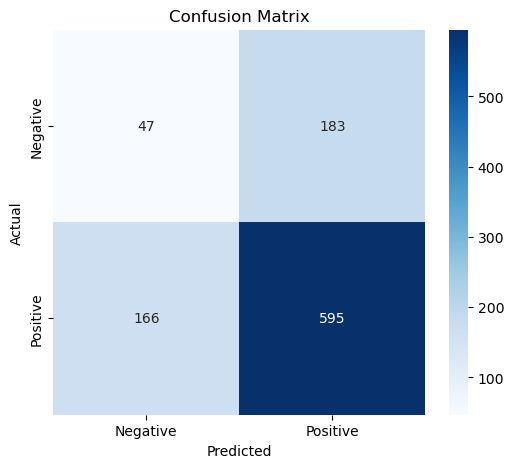

In [85]:
cm = confusion_matrix(true_labels, flattened_predictions)
print("Confusion Matrix:")
print(cm)

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, flattened_predictions))

# Optional: Visualize the confusion matrix
labels = ['Negative', 'Positive']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()